<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Objective</div>

* In this work, i will do a regression analysis on the CYGNSS and SMAP Soil Moisture Data for the year 2020 and 2021
* We will be considered boostings XGBoost algorithm for which we will tuning hyperparameters

<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Library import & Dataset </div>

In [1]:
import warnings
warnings.filterwarnings('ignore')  # ignore notifications

In [2]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

## Data Preparation
+ Combining the CYGNSS features with SMAP soil moisture 
+ Resampling CYGNSS into 36 km grid cell of SMAP
+ Combining 2020 and 2021 data for each grid cell

In [3]:
# import Data_CYGNSS_SM_for_Arema_Sarima_XGBoost
# import imp
# imp.reload(Data_CYGNSS_SM_for_Arema_Sarima_XGBoost)
# import Data_CYGNSS_SM_for_Arema_Sarima_XGBoost as SC1

# lat = [22.18,22.54,22.9,23.26,23.62,23.98,24.34,24.7,25.06,25.42,25.78,26.14,26.5,26.86] 
# lon = [73.18,73.54,73.9,74.26,74.98,75.34,75.7,76.06,76.42,76.78,77.14,77.5,77.86,78.22,78.58,78.94]
# for i in range(len(lat)):
#     for j in range(len(lon)):
#         DF = SC1.Concat(lat[i],lon[j])

## Loading data for a single grid cell

In [4]:
lat = 22.90
lon = 77.86
Data = pd.read_csv(rf'D:\EG\Project Data\ML_Model_Datasets\CYGNSS_SMAP_2020_21_{lat}_{lon}.csv')

In [5]:
Data.keys()

Index(['sp_inc_angle', 'sp_rx_gain', 'gps_tx_power_db_w', 'gps_ant_gain_db_i',
       'ddm_snr', 'ddm_noise_floor', 'rx_to_sp_range', 'tx_to_sp_range',
       'quality_flags', 'peak of power_analog', 'SR_eff', 'Date',
       'SMAP_Soil_Moisture'],
      dtype='object')

### Features:
* sp_inc_angle: Inclination angle of signal to the Nadir of specular point  
* sp_rx_gain: Gain of Receiver Antenna  
* gps_tx_power_db_w: GPS transmitting power
* gps_ant_gain_db_i: Gain of Transmitting Antenna 
* ddm_snr: DDM SNR  
* ddm_noise_floor: DDM Signal to Noise Ratio  
* rx_to_sp_range: Range between Receiver to Specular Point  
* tx_to_sp_range: Range between Transmitter to Specular Point
* quality_flags: Quality flags of the data
* peak of power_analog: Peak of the DDM
* SR_eff: Surface Reflectivity of the Specular point
* Date: Date

### Target variable:
* SMAP_Soil_Moisture: Taken from SMAP in 36 Km grid cell  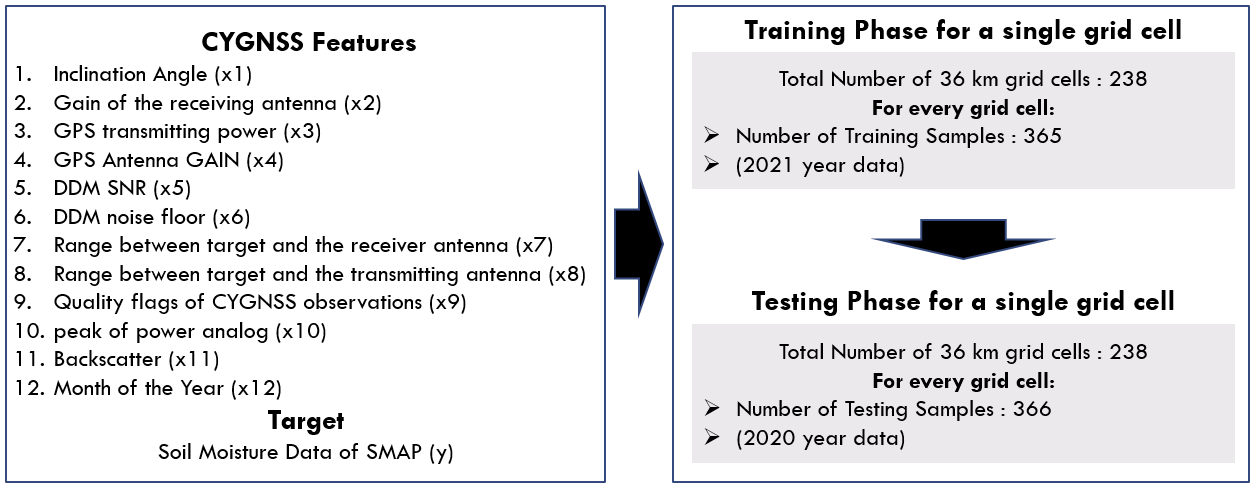

<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">  Data preprocessing </div>

In [6]:
print(f'DataFrame size: {Data.shape}')

DataFrame size: (731, 13)


In [7]:
print(f'Number of missing values in DataFrame:\n{Data.isna().sum()}')

Number of missing values in DataFrame:
sp_inc_angle            291
sp_rx_gain              291
gps_tx_power_db_w       291
gps_ant_gain_db_i       291
ddm_snr                 291
ddm_noise_floor         291
rx_to_sp_range          291
tx_to_sp_range          291
quality_flags           291
peak of power_analog    291
SR_eff                  291
Date                      0
SMAP_Soil_Moisture      103
dtype: int64


In [8]:
Data.describe()

sp_inc_angle  sp_rx_gain  gps_tx_power_db_w  gps_ant_gain_db_i  \
count    440.000000  440.000000         440.000000         440.000000   
mean      25.398859    7.534208          15.443841          14.928855   
std        8.579065    2.969103           0.931349           0.460504   
min        1.964160    0.358846          13.199000          12.802453   
25%       19.981213    5.626366          14.785750          14.650007   
50%       25.829680    7.734749          15.445415          14.895114   
75%       32.015568    9.904731          16.282000          15.194003   
max       39.791294   14.259805          16.875000          16.282037   

          ddm_snr  ddm_noise_floor  rx_to_sp_range  tx_to_sp_range  \
count  440.000000       440.000000      440.000000    4.400000e+02   
mean     7.777119      6393.556173   580595.786400    2.072313e+07   
std      2.939194      1477.208000    36253.874255    3.493138e+05   
min      2.022534      5129.516591   509372.000000    1.992495e+07   
25%      5.451739      5867.705064   552434.035633    2.047129e+07   
50%      7.457202      6183.730038   577932.370000    2.071546e+07   
75%      9.635327      6611.319976   607378.886364    2.098666e+07   
max     20.475033     29497.041000   675241.000000    2.160241e+07   

       quality_flags  peak of power_analog      SR_eff  SMAP_Soil_Moisture  
count   4.400000e+02          4.400000e+02  440.000000          628.000000  
mean    1.999612e+07          5.694937e-17    5.949857            0.248337  
std     1.091807e+08          4.769180e-17    3.816554            0.081319  
min     2.693130e+05          6.220498e-22    0.000122            0.121512  
25%     2.693130e+05          2.246252e-17    3.241777            0.187560  
50%     2.693170e+05          4.329476e-17    5.229226            0.223058  
75%     2.868831e+05          7.593315e-17    7.733225            0.309411  
max     1.074044e+09          3.100710e-16   19.174337            0.396271

In [9]:
def DD_Time(Data):
    Year = []
    for i in range(len(Data)):
        DD = float(np.array(Data['Date'])[i][0:2])/30
        MM = float(np.array(Data['Date'])[i][3:5])
        Year.append(DD+MM)
    Data['Date'] = Year
    return Data
Data = DD_Time(Data) ## Date time column is string make them float

In [10]:
Data = Data.bfill()
Data = Data.ffill()

## Test and Train split

In [11]:
Data_2020 = Data.head(366)  # Test Data
Data_2021 = Data.tail(365)  # Train Data

##  Features and Target variables

In [12]:
X_train = Data_2021.iloc[:,:-1]
y_train = Data_2021.iloc[:,-1]
X_test = Data_2020.iloc[:,:-1]
y_test = Data_2020.iloc[:,-1] 

<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">XGBoost Model Building </p> 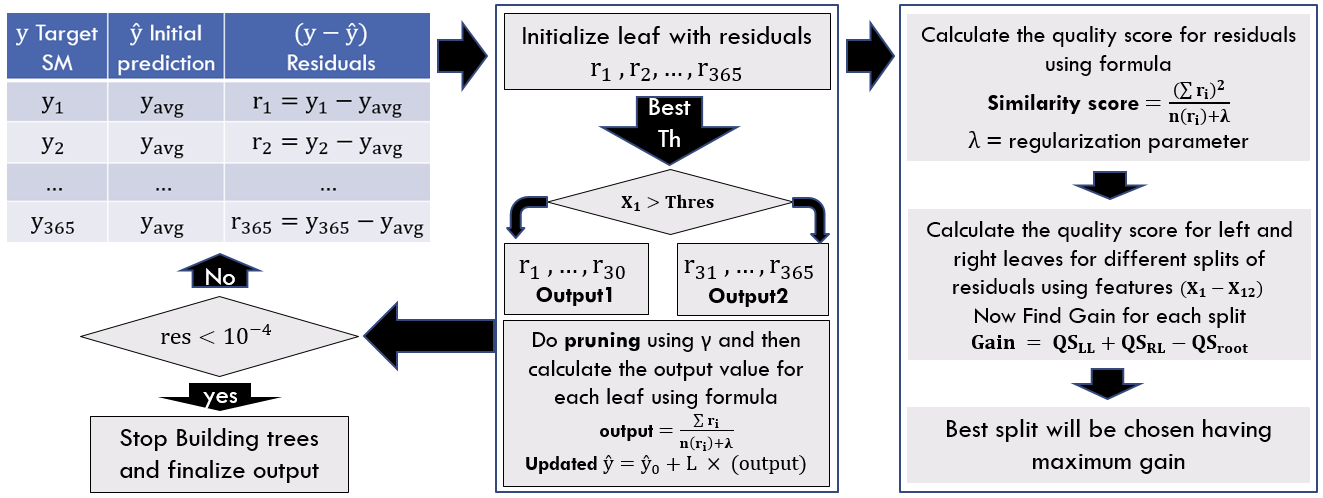

## Training on 2021 Data

In [13]:
xgb_boost = XGBRegressor(n_estimators=2000)
xgb_boost.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_set=[(X_test,y_test)])

[0]	validation_0-rmse:0.19229
[1]	validation_0-rmse:0.14112
[2]	validation_0-rmse:0.10630
[3]	validation_0-rmse:0.08278
[4]	validation_0-rmse:0.06815
[5]	validation_0-rmse:0.05849
[6]	validation_0-rmse:0.05357
[7]	validation_0-rmse:0.05076
[8]	validation_0-rmse:0.04954
[9]	validation_0-rmse:0.04839
[10]	validation_0-rmse:0.04774
[11]	validation_0-rmse:0.04746
[12]	validation_0-rmse:0.04750
[13]	validation_0-rmse:0.04714
[14]	validation_0-rmse:0.04693
[15]	validation_0-rmse:0.04685
[16]	validation_0-rmse:0.04662
[17]	validation_0-rmse:0.04662
[18]	validation_0-rmse:0.04660
[19]	validation_0-rmse:0.04659
[20]	validation_0-rmse:0.04658
[21]	validation_0-rmse:0.04654
[22]	validation_0-rmse:0.04645
[23]	validation_0-rmse:0.04660
[24]	validation_0-rmse:0.04657
[25]	validation_0-rmse:0.04654
[26]	validation_0-rmse:0.04654
[27]	validation_0-rmse:0.04660
[28]	validation_0-rmse:0.04661
[29]	validation_0-rmse:0.04656
[30]	validation_0-rmse:0.04654
[31]	validation_0-rmse:0.04650


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Predicting for 2020 data

In [14]:
y_predt = xgb_boost.predict(X_test)

## Accuracy score R2_score

In [15]:
Accuracy2 = 100*np.round(r2_score(y_test, y_predt),2)
Accuracy2

73.0

## Hyperparameter tuning

In [16]:
def Best_Learning_Rate(L,Acc):
    for i in range(len(L)):
        acc = Acc[i]
        max1 = np.max(Acc)
        if acc==max1:
            lbest = L[i]
    return lbest

In [17]:
## Finding accuracy at all Learning rate
L = np.linspace(0.1,1,100)
Acc2 = []
for i in range(len(L)):
    l = L[i]
    
    ## Training on 2021 Data
    xgb_boost = XGBRegressor(n_estimators=500,learning_rate=l)
    xgb_boost.fit(X_train, y_train)
    
    ## Predicting for 2020 data
    y_predt = xgb_boost.predict(X_test)
    
    ## Accuracy score R2_score
    Accuracy2 = 100*np.round(r2_score(y_test, y_predt),2)
    Acc2.append(Accuracy2)
## Best Learning Rate tunned
xgb_boost = XGBRegressor(learning_rate = Best_Learning_Rate(L,Acc2))
xgb_boost.fit(X_train, y_train)
y_predt = xgb_boost.predict(X_test)
Accuracy_GB = 100*np.round(r2_score(y_test, y_predt),2)

In [18]:
xgb_boost

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.6181818181818182,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [19]:
Accuracy_GB

75.0

## Testing XGBoost Model for 2020 CYGNSS features 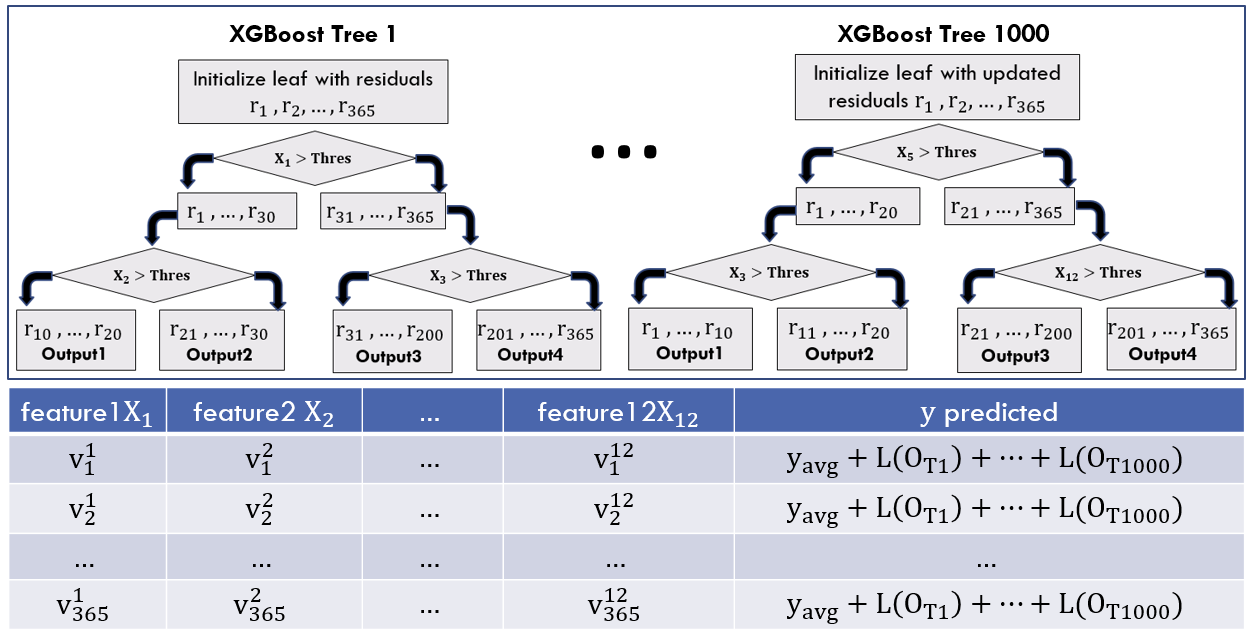

In [20]:
Data_2020['Predicted Soil Moisture'] = y_predt

## Droping Irrelevant Columns

In [21]:
Data_2020 = Data_2020.drop(['sp_inc_angle', 'sp_rx_gain', 'gps_tx_power_db_w',
                                'gps_ant_gain_db_i','ddm_snr', 'ddm_noise_floor', 'rx_to_sp_range', 'tx_to_sp_range',
                                'quality_flags', 'peak of power_analog', 'SR_eff'],axis=1)

<AxesSubplot: >

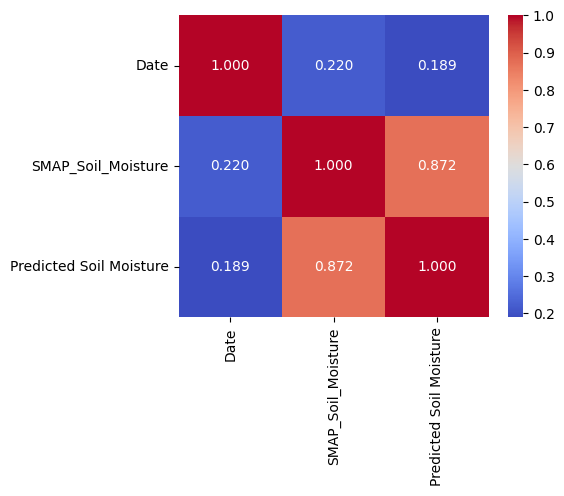

In [22]:
plt.figure(figsize=(5,4),dpi=100)
sns.heatmap(Data_2020.corr(),cmap='coolwarm',fmt=".3f",annot=True)

In [23]:
Data_2020['Date'] = Data_2020.index+1

In [24]:
Data_2021['Date'] = Data_2021.index+1

In [25]:
Data_2021

sp_inc_angle  sp_rx_gain  gps_tx_power_db_w  gps_ant_gain_db_i  \
366     34.120067    8.025971          15.382000          15.308839   
367     29.029182    2.679208          16.392000          14.886079   
368     21.686186    8.118265          14.236875          14.030985   
369     22.464433    2.849900          16.392000          14.486868   
370     35.182338   10.753784          14.392000          15.601218   
..            ...         ...                ...                ...   
726     24.355722    1.733626          15.388500          14.725369   
727     24.355722    1.733626          15.388500          14.725369   
728      9.582840    8.560658          15.487000          14.735311   
729     12.835723    4.900800          15.388500          14.579220   
730     12.835723    4.900800          15.388500          14.579220   

       ddm_snr  ddm_noise_floor  rx_to_sp_range  tx_to_sp_range  \
366   7.445018      6877.674592   625046.461538    2.100587e+07   
367   5.465981      6000.017783   589899.000000    2.111529e+07   
368   4.268200      6406.583394   548609.750000    2.031304e+07   
369   6.396039      5843.973567   558029.666667    2.071823e+07   
370  12.871262      6089.912683   613325.500000    2.128216e+07   
..         ...              ...             ...             ...   
726   3.569608      6358.633020   569308.800000    2.057686e+07   
727   3.569608      6358.633020   569308.800000    2.057686e+07   
728   7.725993      6035.323971   532838.928571    2.020799e+07   
729   5.623974      6399.828125   532158.000000    2.027326e+07   
730   5.623974      6399.828125   532158.000000    2.027326e+07   

     quality_flags  peak of power_analog     SR_eff  Date  SMAP_Soil_Moisture  
366  269313.000000          3.866914e-17   3.750321   367            0.244696  
367  269313.000000          2.233340e-17   6.324790   368            0.244696  
368  269313.000000          1.572141e-17   2.015195   369            0.236502  
369  269313.000000          2.914301e-17   7.727420   370            0.239344  
370  291158.333333          1.443578e-16  11.283107   371            0.274529  
..             ...                   ...        ...   ...                 ...  
726  269317.000000          1.107913e-17   5.103562   727            0.246626  
727  269317.000000          1.107913e-17   5.103562   728            0.246626  
728  269317.000000          4.314513e-17   3.750674   729            0.244865  
729  269317.000000          1.882216e-17   2.917010   730            0.290964  
730  269317.000000          1.882216e-17   2.917010   731            0.236963  

[365 rows x 13 columns]

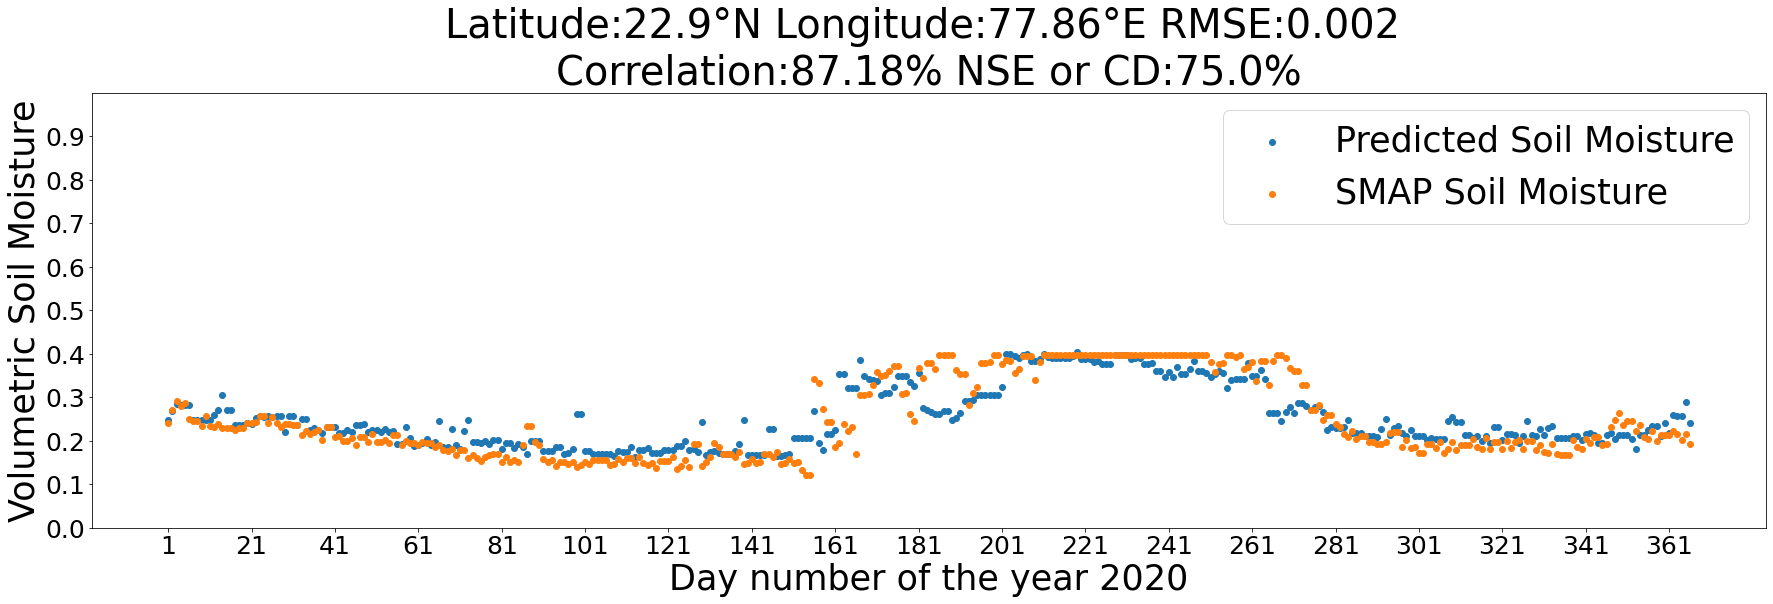

<Figure size 576x576 with 0 Axes>

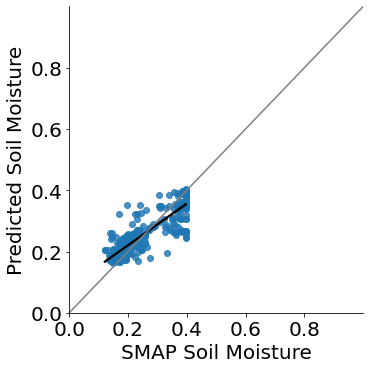

In [26]:
CR = np.array(Data_2020.corr())[1][2]*100
RMSE = round(np.sum((Data_2020['Predicted Soil Moisture'] - Data_2020['SMAP_Soil_Moisture'])**2)/len(Data_2020['SMAP_Soil_Moisture']),3)
plt.figure(figsize=(30,8))
plt.scatter(Data_2020['Date'],Data_2020['Predicted Soil Moisture'],label='Predicted Soil Moisture')
plt.scatter(Data_2020['Date'],Data_2020['SMAP_Soil_Moisture'],label='SMAP Soil Moisture')
plt.title(f'''Latitude:{lat}°N Longitude:{lon}°E RMSE:{round(RMSE,4)} 
Correlation:{np.round(CR,2)}% NSE or CD:{Accuracy_GB}%''',size=40)  
plt.xlabel('Day number of the year 2020',size=35)
plt.ylabel('Volumetric Soil Moisture',size=35)
plt.ylim(0,1)
plt.xticks(np.arange(1, 370, 20),size=25)
plt.yticks(np.arange(0, 1, 0.1),size=25)
plt.legend(fontsize=35)
plt.figure(figsize=(8,8))
sns.lmplot(x=f'SMAP_Soil_Moisture',y=f'Predicted Soil Moisture',data=Data_2020,line_kws={'color': 'black'})
plt.xlabel(f'SMAP Soil Moisture',size=20)
plt.ylabel(f'Predicted Soil Moisture',size=20)
plt.plot([0,1],[0,1],c='gray')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(np.arange(0, 1, 0.2))
plt.yticks(np.arange(0, 1, 0.2))
plt.tick_params(axis='both', labelsize=20)

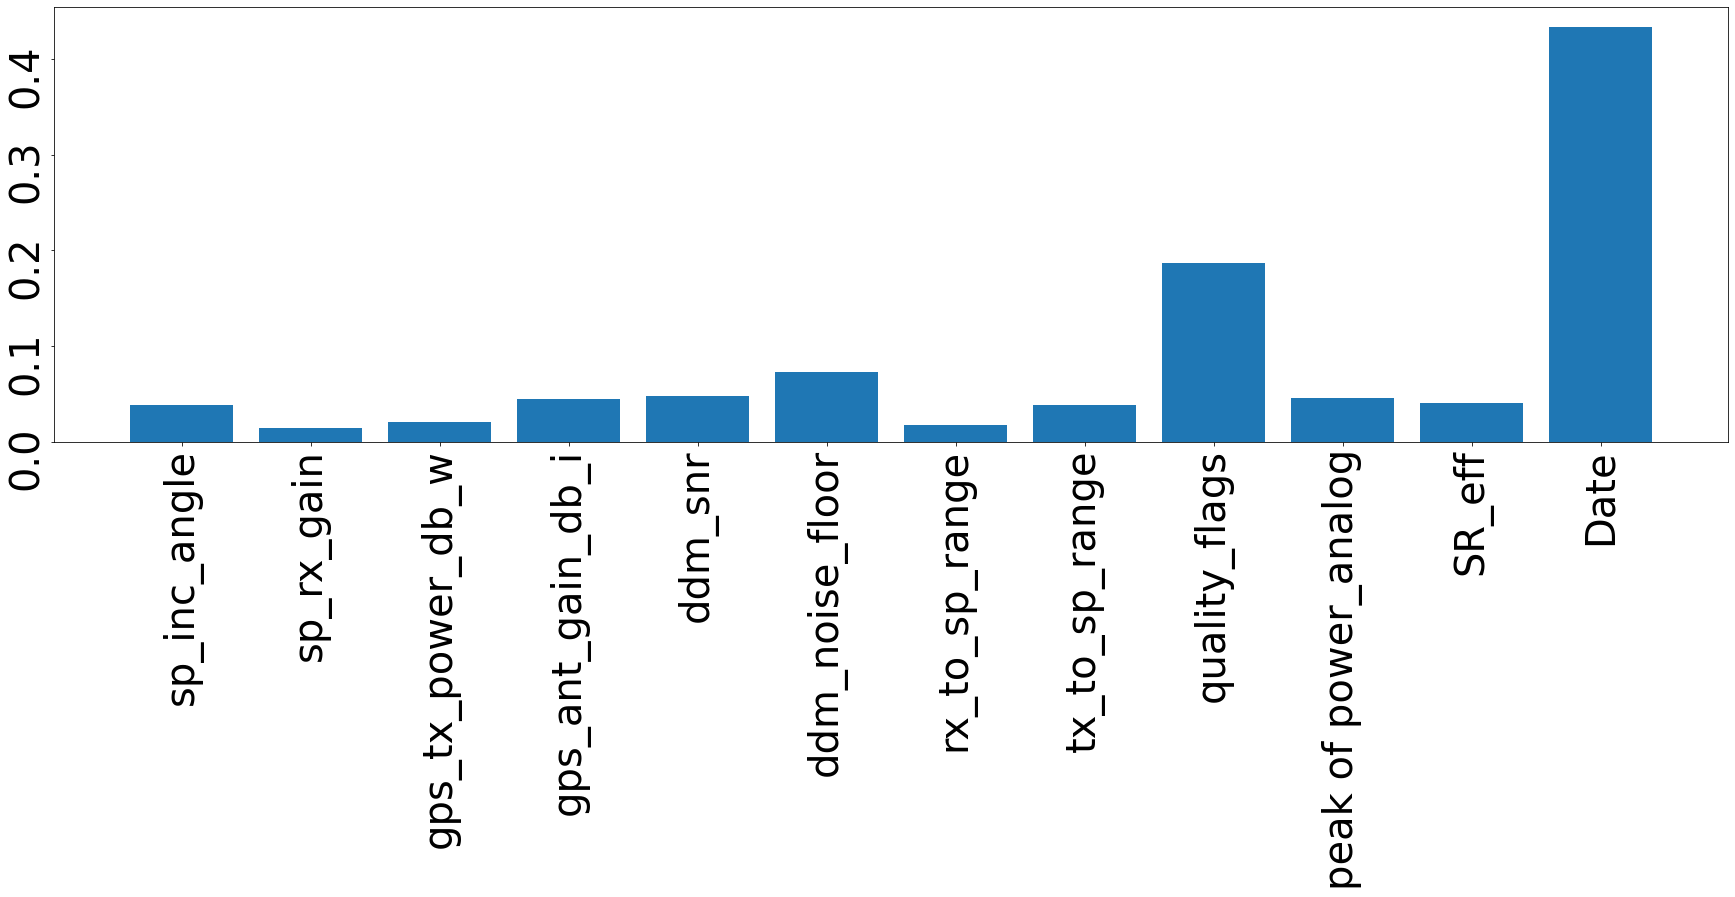

In [27]:
plt.figure(figsize=(30,8))
plt.bar(np.array(Data.iloc[:,:-1].keys()), xgb_boost.feature_importances_)
plt.tick_params(axis='both', labelsize=40, rotation =90)

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Visualizing Performance of Model in the Catchment </p> 

+ After applying XGBoost regression on 238 pixels of the SMAP grid cell

## Applying Kriging Interpolation
+ Interpolated all the metrices in a 3 Km grid cell

In [28]:
lat = [22.18,22.54,22.9,23.26,23.62,23.98,24.34,24.7,25.06,25.42,25.78,26.14,26.5,26.86] 
lon = [73.18,73.54,73.9,74.26,74.98,75.34,75.7,76.06,76.42,76.78,77.14,77.5,77.86,78.22,78.58,78.94]
DF  = pd.read_csv('WCM_Correlations.csv')
DF['CR_SMAP_WCM_RMSE/RMS_SMAP']  = (DF['CR_SMAP_WCM_RMSE']/DF['RMS_SMAP_SM'])**2
DF['WCM_ORG_SMAP_RMSE/RMS_SMAP'] = (DF['WCM_ORG_SMAP_RMSE']/DF['RMS_SMAP_SM'])**2
DF['XGBOOST_SMAP_RMSE/RMS_SMAP'] = (DF['XGBoost_RMSE_SMAP']/DF['RMS_SMAP_SM'])**2

In [29]:
Df1 = np.array(DF['CR_SMAP_WCM_RMSE/RMS_SMAP'])
for i in range(len(Df1)):
    if Df1[i]>0.2:
        Df1[i] = np.mean(Df1)
    else:
        Df1[i] = Df1[i]
DF['CR_SMAP_WCM_RMSE/RMS_SMAP'] = Df1

Df2 = np.array(DF['WCM_ORG_SMAP_RMSE/RMS_SMAP'])
for i in range(len(Df2)):
    if Df2[i]>0.2:
        Df2[i] = np.mean(Df2)
    else:
        Df2[i] = Df2[i]
DF['WCM_ORG_SMAP_RMSE/RMS_SMAP'] = Df2

In [30]:
lon1,lat1 = np.meshgrid(lon,lat)

In [31]:
keys1 = ['CR_SMAP_WCM','CR_GLDAS_WCM','CR_SMAP_GLDAS','CR_SMAP_CYGNSS','WCM_ORG_SMAP_CR','XGBoost_CR_SMAP']
keys2 = ['CR_SMAP_WCM_RMSE','CR_GLDAS_WCM_RMSE','CR_SMAP_GLDAS_RMSE',
         'RMS_SMAP_SM','RMS_LAI_NOAA','WCM_ORG_SMAP_RMSE','XGBoost_RMSE_SMAP','CR_SMAP_CYGNSS_RMSE',
         'CR_SMAP_WCM_RMSE/RMS_SMAP','WCM_ORG_SMAP_RMSE/RMS_SMAP','XGBOOST_SMAP_RMSE/RMS_SMAP']

In [32]:
K = keys1[0]

In [33]:
K1 = np.array(DF[f'{K}']).reshape(len(lat),len(lon))

In [34]:
import skgstat as skg
from skgstat import Variogram

+ With a Variogram, we will basically try to find and describe some systematic statistical behavior from these similarities. 
+ The process of grouping distance data together is called binning.

+ The OrdinaryKriging class need at least a fitted Variogram instance. + Using min_points we can demand the Kriging equation system to be build upon at least 5 points to yield robust results. 
+ If not enough close observations are found within the effective range of the variogram, the estimation will not be calculated and a np.NaN value is estimated.
+ The max_points parameter will set the upper bound of the equation system by using in this case at last the 20 nearest points. 
+ Adding more will most likely not change the estimation, as more points will recieve small, if not negligible, weights. 
+ But it will increase the processing time, as each added point will increase the Kriging equation system dimensionality by one.
+ The mode parameter sets the method that will build up the equation system. 
+ There are two implemented: mode=’exact’ and mode=’estimate’. 

In [35]:
from skgstat import OrdinaryKriging

In [36]:
def Interpolating_Krigging(data):
  xx, yy = np.mgrid[22:27:0.03, 73:79:0.03]
  DFf = pd.DataFrame(xx.flatten())
  DFf.columns = ['Lat']
  DFf['Lon']  = yy.flatten()

  Keys = ['CR_SMAP_WCM', 'CR_SMAP_WCM_RMSE', 'CR_GLDAS_WCM', 'CR_GLDAS_WCM_RMSE',
       'CR_SMAP_GLDAS', 'XGBoost_CR_SMAP','CR_SMAP_GLDAS_RMSE','XGBoost_RMSE_SMAP', 'CR_SMAP_CYGNSS', 'RMS_SMAP_SM',
       'RMS_LAI_NOAA', 'WCM_ORG_SMAP_CR', 'WCM_ORG_SMAP_RMSE','CR_SMAP_CYGNSS_RMSE', 
       'CR_SMAP_WCM_RMSE/RMS_SMAP','WCM_ORG_SMAP_RMSE/RMS_SMAP','XGBOOST_SMAP_RMSE/RMS_SMAP']
  for K in Keys:
    V  = Variogram(data[['Lat', 'Lon']].values, data[f'{K}'].values,maxlag=5, n_lags=25, model='gaussian',normalize=False)
    ok = OrdinaryKriging(V, min_points=1, max_points=3, mode='exact')
    field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    DFf[f'{K}'] = field.flatten()
  return DFf

In [37]:
%%time
DFf = Interpolating_Krigging(DF)

Wall time: 1min 31s


In [38]:
Keys = ['CR_SMAP_WCM', 'CR_SMAP_WCM_RMSE', 'CR_GLDAS_WCM', 'CR_GLDAS_WCM_RMSE',
       'CR_SMAP_GLDAS', 'XGBoost_CR_SMAP','CR_SMAP_GLDAS_RMSE','XGBoost_RMSE_SMAP', 'CR_SMAP_CYGNSS', 'RMS_SMAP_SM',
       'RMS_LAI_NOAA', 'WCM_ORG_SMAP_CR', 'WCM_ORG_SMAP_RMSE','CR_SMAP_CYGNSS_RMSE', 
       'CR_SMAP_WCM_RMSE/RMS_SMAP','WCM_ORG_SMAP_RMSE/RMS_SMAP','XGBOOST_SMAP_RMSE/RMS_SMAP']

In [39]:
%%time
for K in Keys:
  DDM = DFf[f'{K}']
  DDM1 = DF[f'{K}']
  for i in range(len(DDM)):
    DDM2 = DDM[i]
    if DDM2>max(DDM1) or DDM2<min(DDM1):
      DDM[i] = np.nan
    else:
      DDM[i] = DDM[i]
  DFf[f'{K}'] = DDM

Wall time: 2min 13s


In [40]:
DFf.shape

(33400, 19)

In [41]:
DFf1 = pd.read_csv('WCM_Correlations_3Km.csv')
DFf1.shape

(33400, 19)

In [42]:
DFf.keys()

Index(['Lat', 'Lon', 'CR_SMAP_WCM', 'CR_SMAP_WCM_RMSE', 'CR_GLDAS_WCM',
       'CR_GLDAS_WCM_RMSE', 'CR_SMAP_GLDAS', 'XGBoost_CR_SMAP',
       'CR_SMAP_GLDAS_RMSE', 'XGBoost_RMSE_SMAP', 'CR_SMAP_CYGNSS',
       'RMS_SMAP_SM', 'RMS_LAI_NOAA', 'WCM_ORG_SMAP_CR', 'WCM_ORG_SMAP_RMSE',
       'CR_SMAP_CYGNSS_RMSE', 'CR_SMAP_WCM_RMSE/RMS_SMAP',
       'WCM_ORG_SMAP_RMSE/RMS_SMAP', 'XGBOOST_SMAP_RMSE/RMS_SMAP'],
      dtype='object')

In [43]:
DFf = DFf.drop(['CR_SMAP_WCM', 'CR_SMAP_WCM_RMSE', 'CR_GLDAS_WCM',
       'CR_GLDAS_WCM_RMSE', 'CR_SMAP_GLDAS',
       'CR_SMAP_GLDAS_RMSE', 'CR_SMAP_CYGNSS', 'RMS_LAI_NOAA', 'WCM_ORG_SMAP_CR', 'WCM_ORG_SMAP_RMSE',
       'CR_SMAP_CYGNSS_RMSE', 'CR_SMAP_WCM_RMSE/RMS_SMAP',
       'WCM_ORG_SMAP_RMSE/RMS_SMAP'],axis=1)
DFf.keys()

Index(['Lat', 'Lon', 'XGBoost_CR_SMAP', 'XGBoost_RMSE_SMAP', 'RMS_SMAP_SM',
       'XGBOOST_SMAP_RMSE/RMS_SMAP'],
      dtype='object')

In [44]:
Listed = ['XGBoost_CD_SMAP']
Listed2 = ['XGBoost_CR_SMAP']
for CD,CR in zip(Listed,Listed2):
  DFf[f'{CD}'] = (((np.array(DFf[f'{CR}']))/100)**2)*100

In [45]:
DFf.head()

Lat    Lon  XGBoost_CR_SMAP  XGBoost_RMSE_SMAP  RMS_SMAP_SM  \
0  22.0  73.00        67.347712           0.005947     0.230523   
1  22.0  73.03        67.449749           0.005871     0.229157   
2  22.0  73.06        67.551268           0.005794     0.227771   
3  22.0  73.09        67.652179           0.005716     0.226367   
4  22.0  73.12        67.752395           0.005637     0.224945   

   XGBOOST_SMAP_RMSE/RMS_SMAP  XGBoost_CD_SMAP  
0                    0.000672        45.357143  
1                    0.000662        45.494687  
2                    0.000652        45.631738  
3                    0.000642        45.768174  
4                    0.000632        45.903870

<AxesSubplot: xlabel='XGBOOST_SMAP_RMSE/RMS_SMAP', ylabel='Count'>

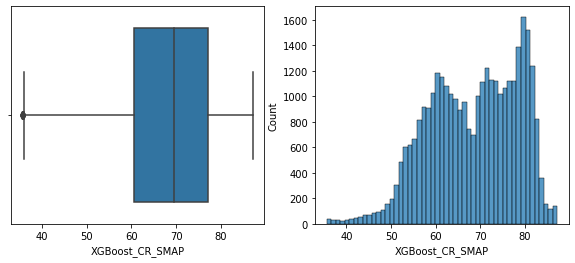

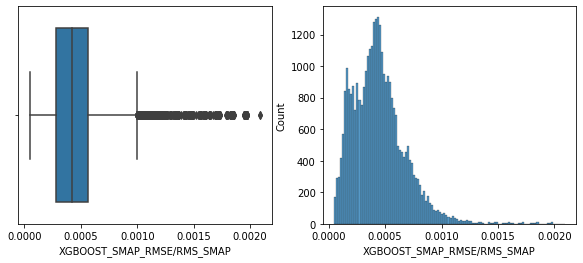

In [46]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(DFf['XGBoost_CR_SMAP'])
plt.subplot(1,2,2)
sns.histplot(DFf['XGBoost_CR_SMAP'])

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(DFf['XGBOOST_SMAP_RMSE/RMS_SMAP'])
plt.subplot(1,2,2)
sns.histplot(DFf['XGBOOST_SMAP_RMSE/RMS_SMAP'])

In [47]:
V1 = '''Correlation of XGBoost predicted with 
SMAP Soil Moisture'''
V2 = '''R2 Score of XGBoost and 
SMAP Soil Moisture'''

V3 = '''RMSE of XGBoost predicted with
SMAP Soil Moisture'''
V4 = '''Relative Error of XGBoost predicted
wrt SMAP Soil Moisture'''

In [48]:
keys11 = ['XGBoost_CR_SMAP','XGBoost_CD_SMAP']
keys22 = ['XGBoost_RMSE_SMAP','XGBOOST_SMAP_RMSE/RMS_SMAP']
keys1 = [f'{V1}',f'{V2}']
keys2 = [f'{V3}',f'{V4}']

In [49]:
for j1,i1 in zip(keys11,keys1):
    DFf[f'{i1}'] = DFf[f'{j1}']
    
for j1,i1 in zip(keys22,keys2):
    DFf[f'{i1}'] = DFf[f'{j1}']

## Visualization of performance on Map

In [51]:
import geopandas as gpd
fp = r'indian_districts.shp'
map_df = gpd.read_file(fp) 
map_df_msk = map_df[((map_df['latitude']>21.5) & (map_df['latitude']<27.5)) & ((map_df['longitude']>72.5) & (map_df['longitude']<79.5))]
DF3 = map_df_msk
DF3 = DF3[DF3['state nam0']!='Uttar Pradesh']
DF3 = DF3[DF3['state nam0']!='Chhattisgarh']

In [52]:
for CD,CR in zip(Listed,Listed2):
  DFf[f'{CD}'] = (((np.array(DFf[f'{CR}']))/100)**2)*100

In [53]:
for j1,i1 in zip(keys11,keys1):
    DFf[f'{i1}'] = DFf[f'{j1}']
    
for j1,i1 in zip(keys22,keys2):
    DFf[f'{i1}'] = DFf[f'{j1}']

In [54]:
lat_K, lon_K = np.mgrid[22:27:0.03, 73:79:0.03]
m,n = lat_K.shape
m,n

(167, 200)

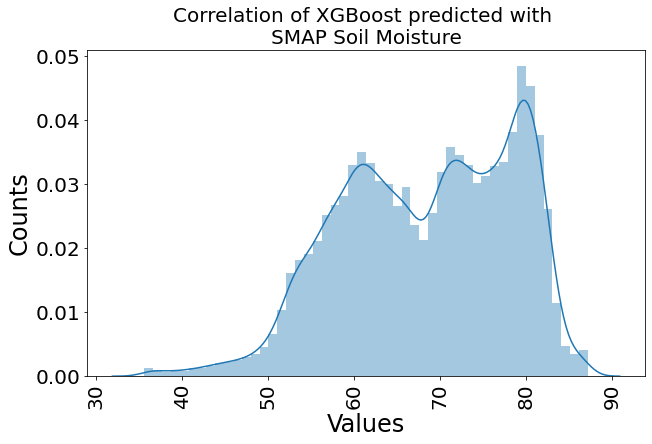

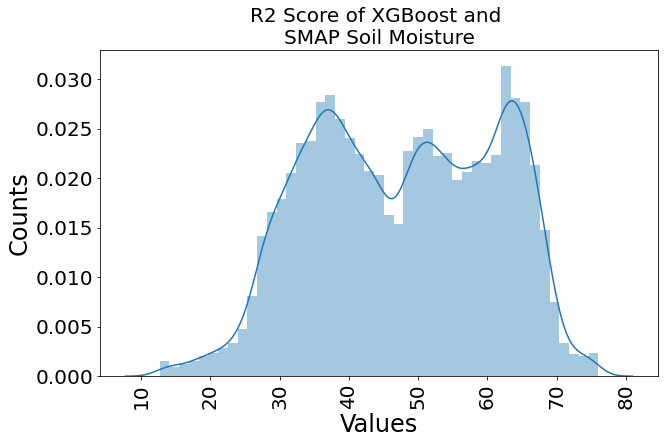

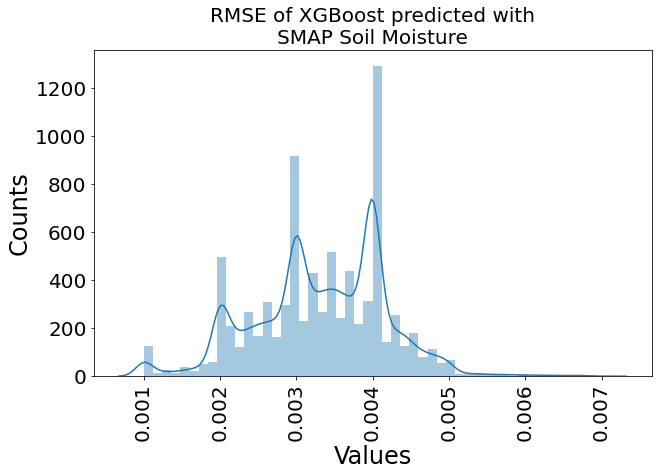

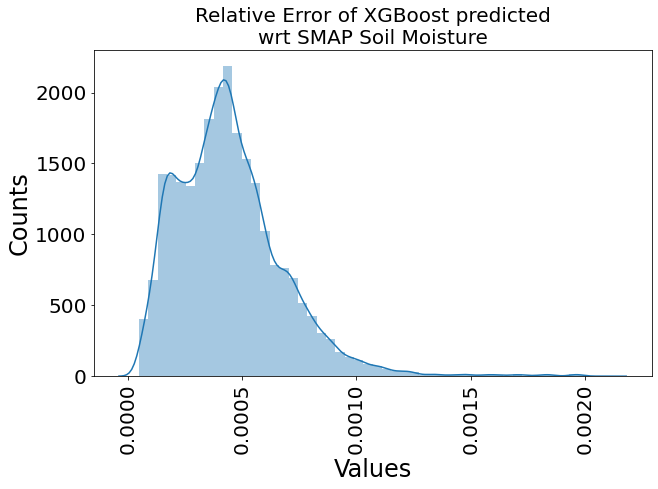

In [55]:
V = [V1,V2,V3,V4]
for V in V:
    plt.figure(figsize=(10,6))
    sns.distplot(np.array(DFf[f'{V}']).flatten())
    plt.xlabel(f'Values',fontsize=24)
    plt.ylabel('Counts',fontsize=24)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='x', which='major',rotation=90)
    plt.title(f'{V}',fontsize=20)

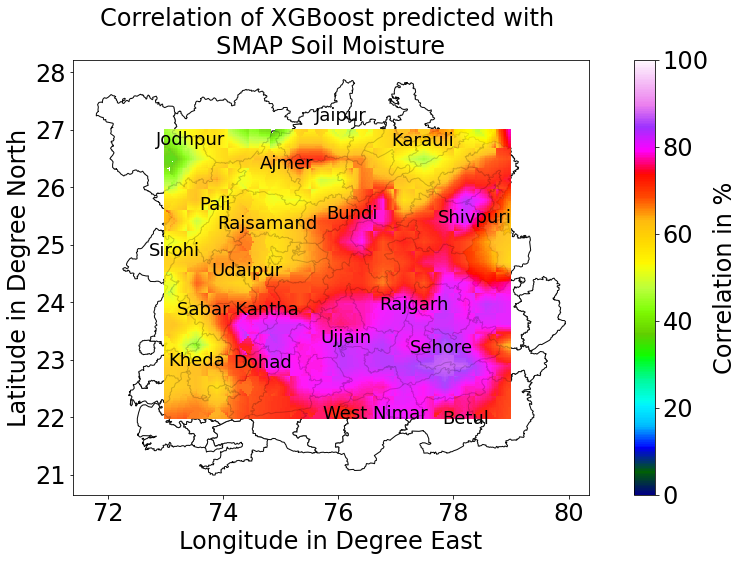

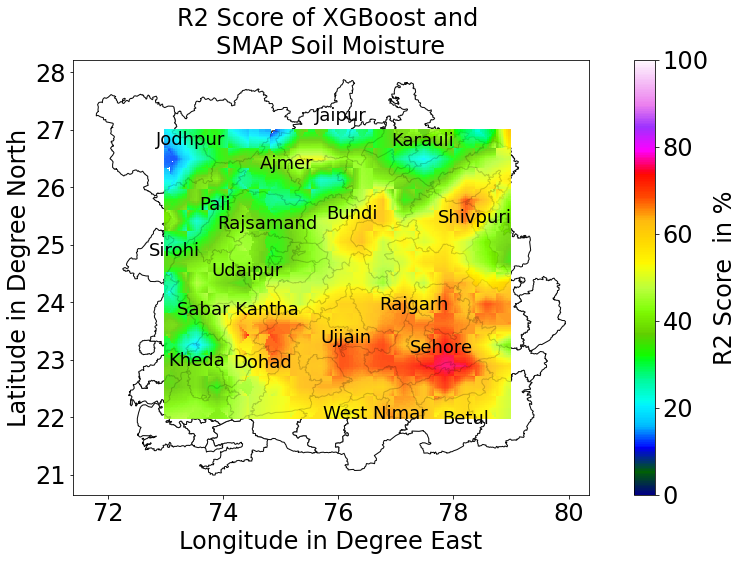

In [56]:
for K in keys1:
    K1 = np.array(DFf[f'{K}']).reshape(m,n)
    fig , ax = plt.subplots(figsize=(16, 8))
    DF3.plot(color = 'white',edgecolor = 'black',axes=ax)
    plt.pcolor(lon_K, lat_K, K1,cmap="gist_ncar",vmin=0,vmax=100)
    DF3.plot(color = 'white', edgecolor = 'black',axes=ax,alpha=0.1)
    plt.xlabel('Longitude in Degree East',fontsize=24)
    plt.ylabel('Latitude in Degree North',fontsize=24)
    cbar = plt.colorbar()
    cbar.set_label(f'{K[:11].replace("of","")} in %',fontsize=24)
    cbar.ax.tick_params(labelsize=24)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.clim(0, 100)
    S1 = ['Panch Mahals', 'Dungarpur', 'Dausa', 'Mandsaur', 'Bharuch',
          'Damoh', 'Narsimhapur', 'Narmada', 'Nandurbar', 'Barwani','Dhar',
          'Ratlam', 'Datia', 'Shajapur', 'Morena', 'Jhalawar', 'Dewas',
          'Bhilwara', 'Raisen', 'Vidisha', 'Chhindwara']
    for i in range(1,len(DF3),2):
      X = DF3['longitude'].iloc[i]
      Y = DF3['latitude'].iloc[i]
      S = DF3['district n'].iloc[i]
      S = S.replace("*","")
      S = S[9:]
      if S not in S1:
        plt.text(X,Y,S,fontsize=18,alpha=1)
    plt.title(f'''{K}''',fontsize=24)

Text(0.5, 1.0, 'Relative Error of XGBoost predicted\nwrt SMAP Soil Moisture')

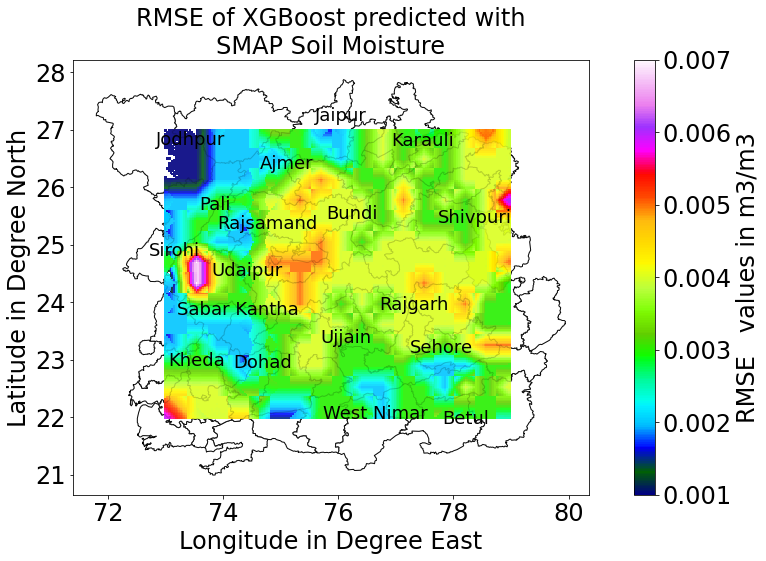

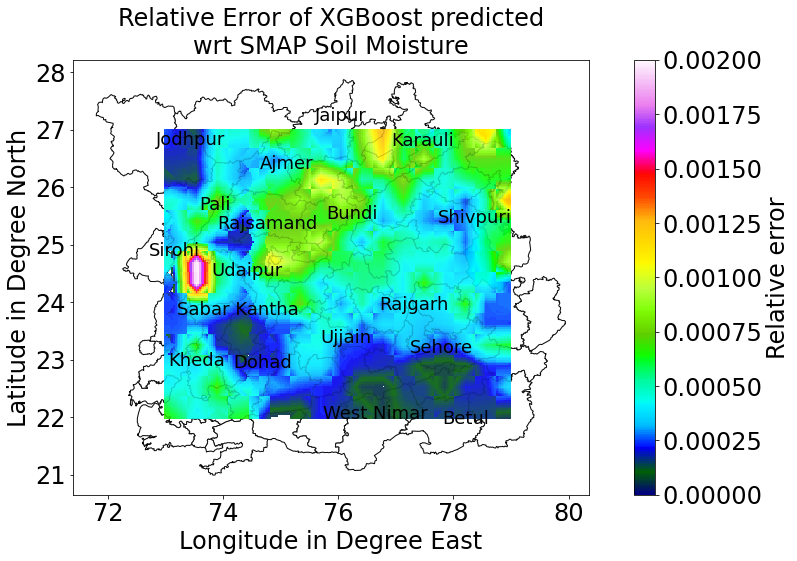

In [57]:
K  = keys2[0]
K1 = np.array(DFf[f'{K}']).reshape(m,n)
fig , ax = plt.subplots(figsize=(16,8))
DF3.plot(color = 'white',edgecolor = 'black',axes=ax)
plt.pcolor(lon_K, lat_K, K1,cmap="gist_ncar",vmin=0,vmax=1)
DF3.plot(color = 'white', edgecolor = 'black',axes=ax,alpha=0.1)
plt.xlabel('Longitude in Degree East',fontsize=24)
plt.ylabel('Latitude in Degree North',fontsize=24)
cbar = plt.colorbar()
cbar.set_label(f'{K[:8].replace("of","")} values in m3/m3',fontsize=24)
cbar.ax.tick_params(labelsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.clim(0.001, 0.007)
for i in range(1,len(DF3),2):
  X = DF3['longitude'].iloc[i]
  Y = DF3['latitude'].iloc[i]
  S = DF3['district n'].iloc[i]
  S = S.replace("*","")
  S = S[9:]
  if S not in S1:
    plt.text(X,Y,S,fontsize=18,alpha=1)
plt.title(f'''{K}''',fontsize=24)

K  = keys2[1]
K1 = np.array(DFf[f'{K}']).reshape(m,n)
fig , ax = plt.subplots(figsize=(16,8))
DF3.plot(color = 'white',edgecolor = 'black',axes=ax)
plt.pcolor(lon_K, lat_K, K1,cmap="gist_ncar",vmin = np.min(DFf[f'{K}']), vmax=np.max(DFf[f'{K}']))
DF3.plot(color = 'white', edgecolor = 'black',axes=ax,alpha=0.1)
plt.xlabel('Longitude in Degree East',fontsize=24)
plt.ylabel('Latitude in Degree North',fontsize=24)
cbar = plt.colorbar()
cbar.set_label(f'{K[:8].replace("of","")} error',fontsize=24)
cbar.ax.tick_params(labelsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.clim(0, 0.002)
for i in range(1,len(DF3),2):
  X = DF3['longitude'].iloc[i]
  Y = DF3['latitude'].iloc[i]
  S = DF3['district n'].iloc[i]
  S = S.replace("*","")
  S = S[9:]
  if S not in S1:
    plt.text(X,Y,S,fontsize=18,alpha=1)
plt.title(f'''{K}''',fontsize=24)

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">With Land Cover Type</p>

In [58]:
from tifffile import tifffile
from matplotlib.colors import LinearSegmentedColormap

tile3   = tifffile.imread('E060N40_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif')
Tile1   = np.array(tile3)
lat_LC,lon_LC = np.arange(20,40,0.0009921), np.arange(60,100,0.00099211)
lat_LC = lat_LC[2016:7056:5]
lon_LC = lon_LC[13104:19152:5]
Tile2  = Tile1[-7056:-2016:5,13104:19152:5]
lat3 = lat_LC[::-1]
lon3 = lon_LC
lon_,lat_ = np.meshgrid(lon3,lat3)

+ 1. With 100 m resolution LC 
### 36 Km grid cell contour plot

In [59]:
Listed_Cover = ['Shrubs','Herbaceous vegetation','vegetated cropland','Built up','Sparse vegetation',
                             'Permanent water bodies','Herbaceous wetland','Closed forest, evergreen needle leaf',
                             'Closed forest, evergreen, broad leaf','Closed forest, deciduous broad leaf',
                             'Closed forest, unknown','Open forest, evergreen needle leaf','Open forest, evergreen broad leaf',
                             'Open forest, deciduous broad leaf','Open forest, unknown']

### Creating Standard Colors for the Land Cover

In [60]:
colors = [(255/255,187/255,34/255),(255/255,255/255,76/255),(240/255,150/255,255/255),
          (250/255,0/255,0/255),
          (180/255, 180/255, 180/255),(0/255, 50/255, 200/255),(0/255, 150/255, 160/255),
          (88/255, 72/255, 31/255),
          (0/255, 153/255, 0/255),(0/255, 204/255, 0/255),(0/255, 120/255, 0/255),
          (102/255, 96/255, 0/255),(141/255, 180/255, 0/255),
          (160/255, 220/255, 0/255),(100/255, 140/255, 0/255)] 
cmap_name = 'my_list'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=15)
Tick = [20/255,30/255,40/255,50/255,60/255,70/255,80/255,90/255,100/255,110/255,120/255,130/255,140/255,150/255,160/255]

In [61]:
Font = '''Shrubs(5.639%)\n
Herbaceous vegetation(6.27 %)\n
vegetated cropland(76.29 %)\n
Built up(1.65 %)\n
Sparse vegetation(0.35 %)\n
Permanent water bodies(0.546 %)\n
Herbaceous wetland(0.51 %)\n
Closed Forest(3-5 %)\n
Open forest(5-6 %)'''

In [62]:
TDF = pd.DataFrame(Tile2)
TDF = TDF.replace(80,70)
TDF = TDF.replace(90,80)
TDF = TDF.replace(111,90)
TDF = TDF.replace(112,100)
TDF = TDF.replace(114,110)
TDF = TDF.replace(116,120)
TDF = TDF.replace(121,130)
TDF = TDF.replace(122,140)
TDF = TDF.replace(124,150)
TDF = TDF.replace(126,160)

In [63]:
TDF  = np.array(TDF)

In [64]:
n1 = 5

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Resampled Land Cover with Maps</p> 

+ https://www.researchgate.net/post/Can-anyone-provide-a-shape-file-of-Indian-Districts/553a4a5ad4c11848798b45a4/citation/download. 

In [65]:
def Plotting5(K,n1):
    K1 = np.array(DFf[f'{K}']).reshape(m,n)
    fig , ax = plt.subplots(figsize=(40, 20))
    DF3.plot(color = 'white',edgecolor = 'black',axes=ax)
    plt.pcolor(lon_,lat_,TDF/255,cmap=cmap)
    DF3.plot(color = "white", edgecolor = 'black',axes=ax,alpha=0.1)
    cbar = plt.colorbar(ticks=Tick)
    cbar.ax.set_yticklabels(Listed_Cover,fontsize=25)
    cbar.set_label(f'Land Cover Type',fontsize=25)
    
    contours = plt.contour(lon_K,lat_K,K1,n1, vmin=0,vmax=100,colors='k',alpha=0.8)
    plt.clabel(contours, inline=True, fontsize=30,colors='black', fmt='%1.0f')
    plt.xlabel('Longitude in degree East',fontsize=35)
    plt.ylabel('Latitude in degree North',fontsize=35)
    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.title(f'''{K} with Contour Level: {n1}''',fontsize=30)

    S1 = ['Panch Mahals', 'Dungarpur', 'Dausa', 'Mandsaur', 'Bharuch',
          'Damoh', 'Narsimhapur', 'Narmada', 'Nandurbar', 'Barwani','Dhar',
          'Ratlam', 'Datia', 'Shajapur', 'Morena', 'Jhalawar', 'Dewas']
    for i in range(len(DF3)):
      X = DF3['longitude'].iloc[i]
      Y = DF3['latitude'].iloc[i]
      S = DF3['district n'].iloc[i]
      S = S.replace("*","")
      S = S[9:]
      if S not in S1:
        plt.text(X,Y,S,fontsize=25,alpha=1)
    
def Plotting6(K,n1):
    K1 = np.array(DFf[f'{K}']).reshape(m,n)
    fig , ax = plt.subplots(figsize=(40, 20))
    DF3.plot(color = 'white',edgecolor = 'black',axes=ax)
    plt.pcolor(lon_,lat_,TDF/255,cmap=cmap,alpha=0.8)
    DF3.plot(color = 'white', edgecolor = 'black',axes=ax,alpha=0.1)
    cbar = plt.colorbar(ticks=Tick)
    cbar.ax.set_yticklabels(Listed_Cover,fontsize=15)
    cbar.set_label(f'Land Cover Type',fontsize=15)
    
    contours = plt.contour(lon_K,lat_K,K1,n1, vmin=0,vmax=1,colors='k',alpha=0.8)
    plt.clabel(contours, inline=True, fontsize=20,colors='black', fmt='%1.3f')
    plt.xlabel('Longitude in degree East',fontsize=35)
    plt.ylabel('Latitude in degree North',fontsize=35)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.title(f'''{K} with Contour Level: {n1}''',fontsize=30)
    S1 = ['Panch Mahals', 'Dungarpur', 'Dausa', 'Mandsaur', 'Bharuch',
          'Damoh', 'Narsimhapur', 'Narmada', 'Nandurbar', 'Barwani','Dhar',
          'Ratlam', 'Datia', 'Shajapur', 'Morena', 'Jhalawar', 'Dewas']
    for i in range(len(DF3)):
      X = DF3['longitude'].iloc[i]
      Y = DF3['latitude'].iloc[i]
      S = DF3['district n'].iloc[i]
      S = S.replace("*","")
      S = S[9:]
      if S not in S1:
        plt.text(X,Y,S,fontsize=25,alpha=1)

Wall time: 18.9 s


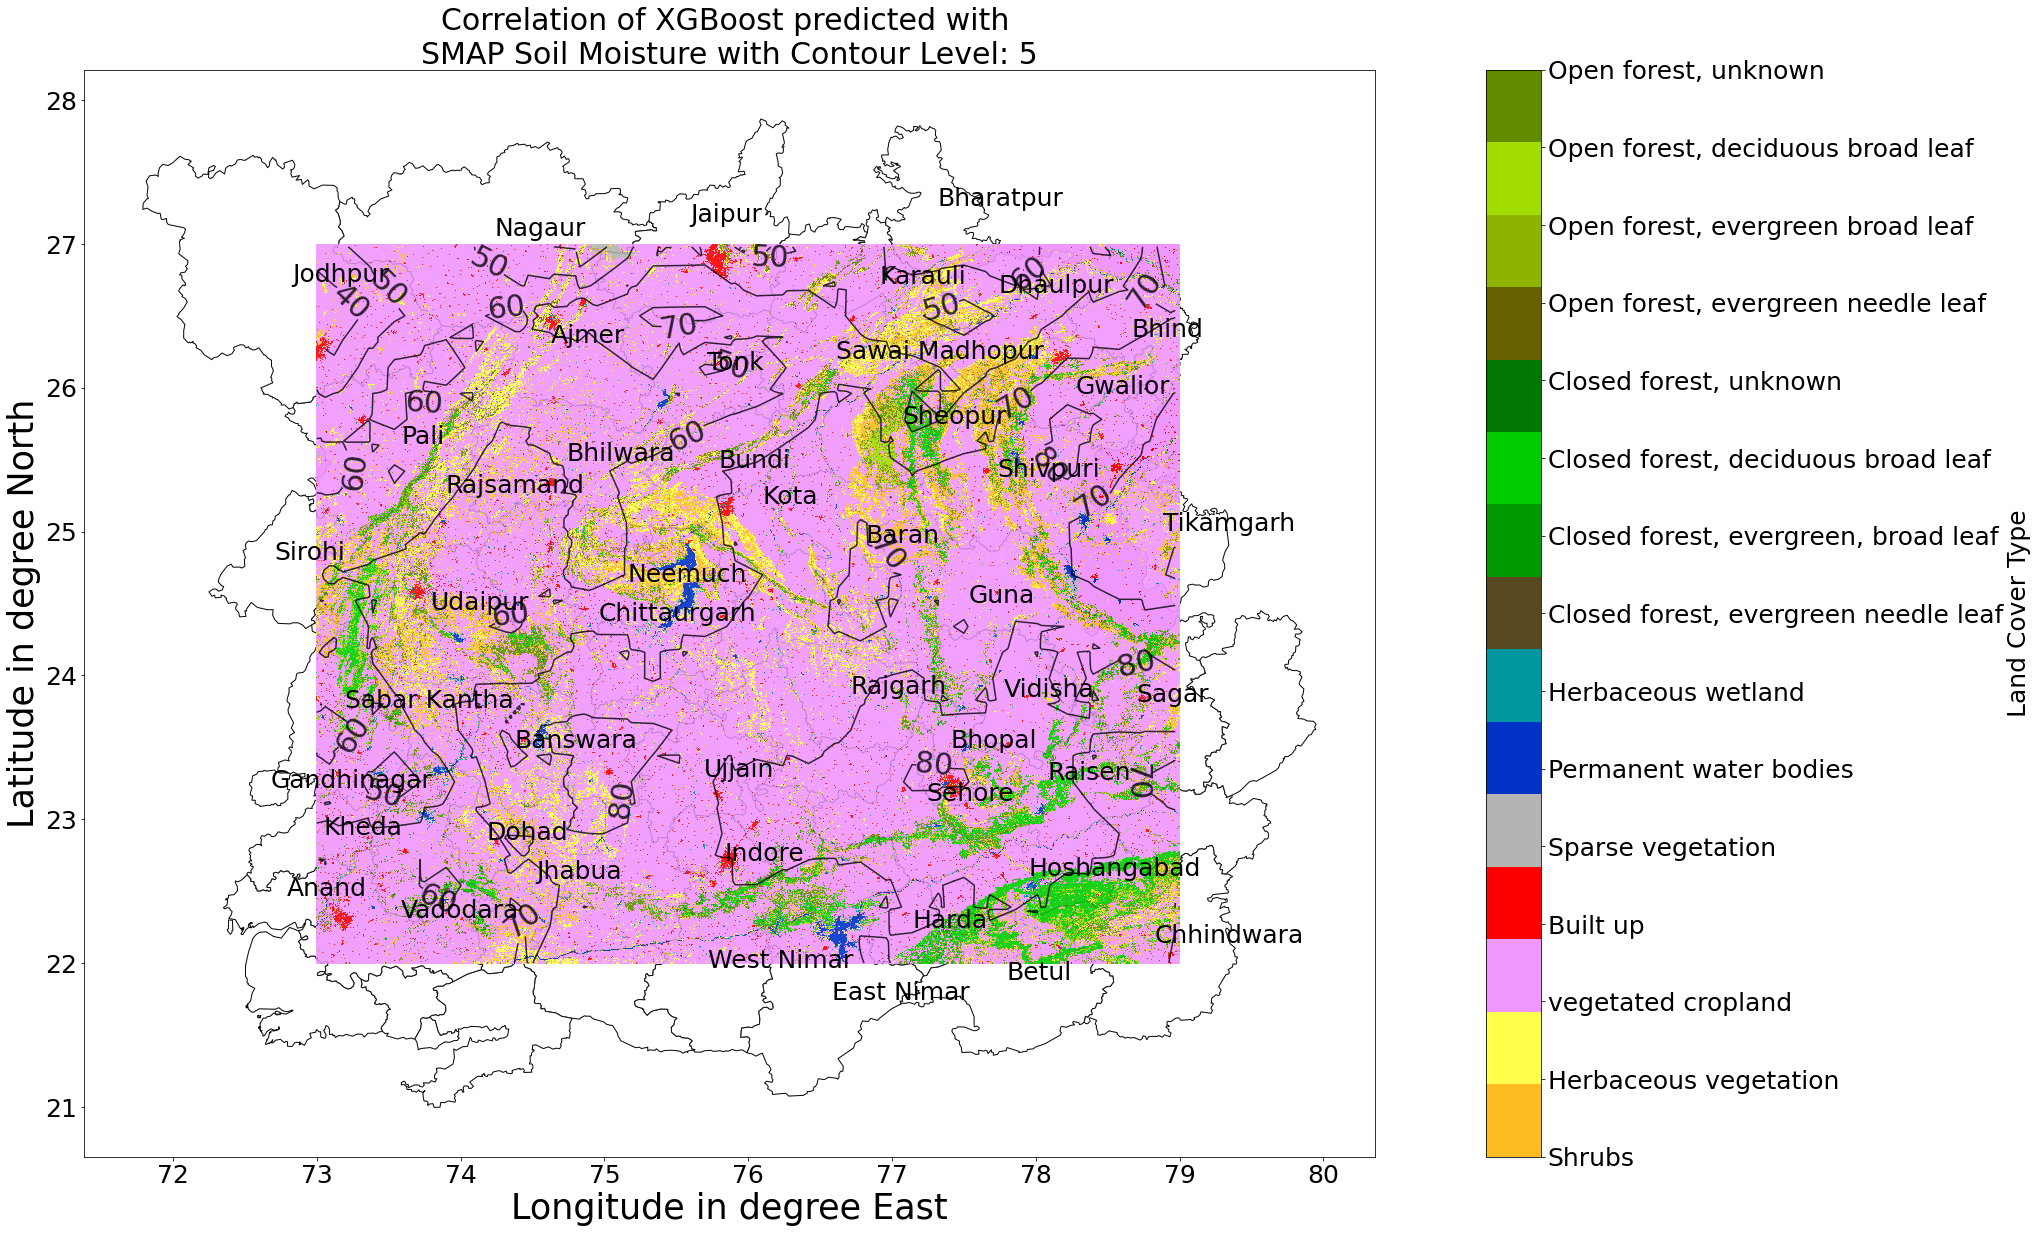

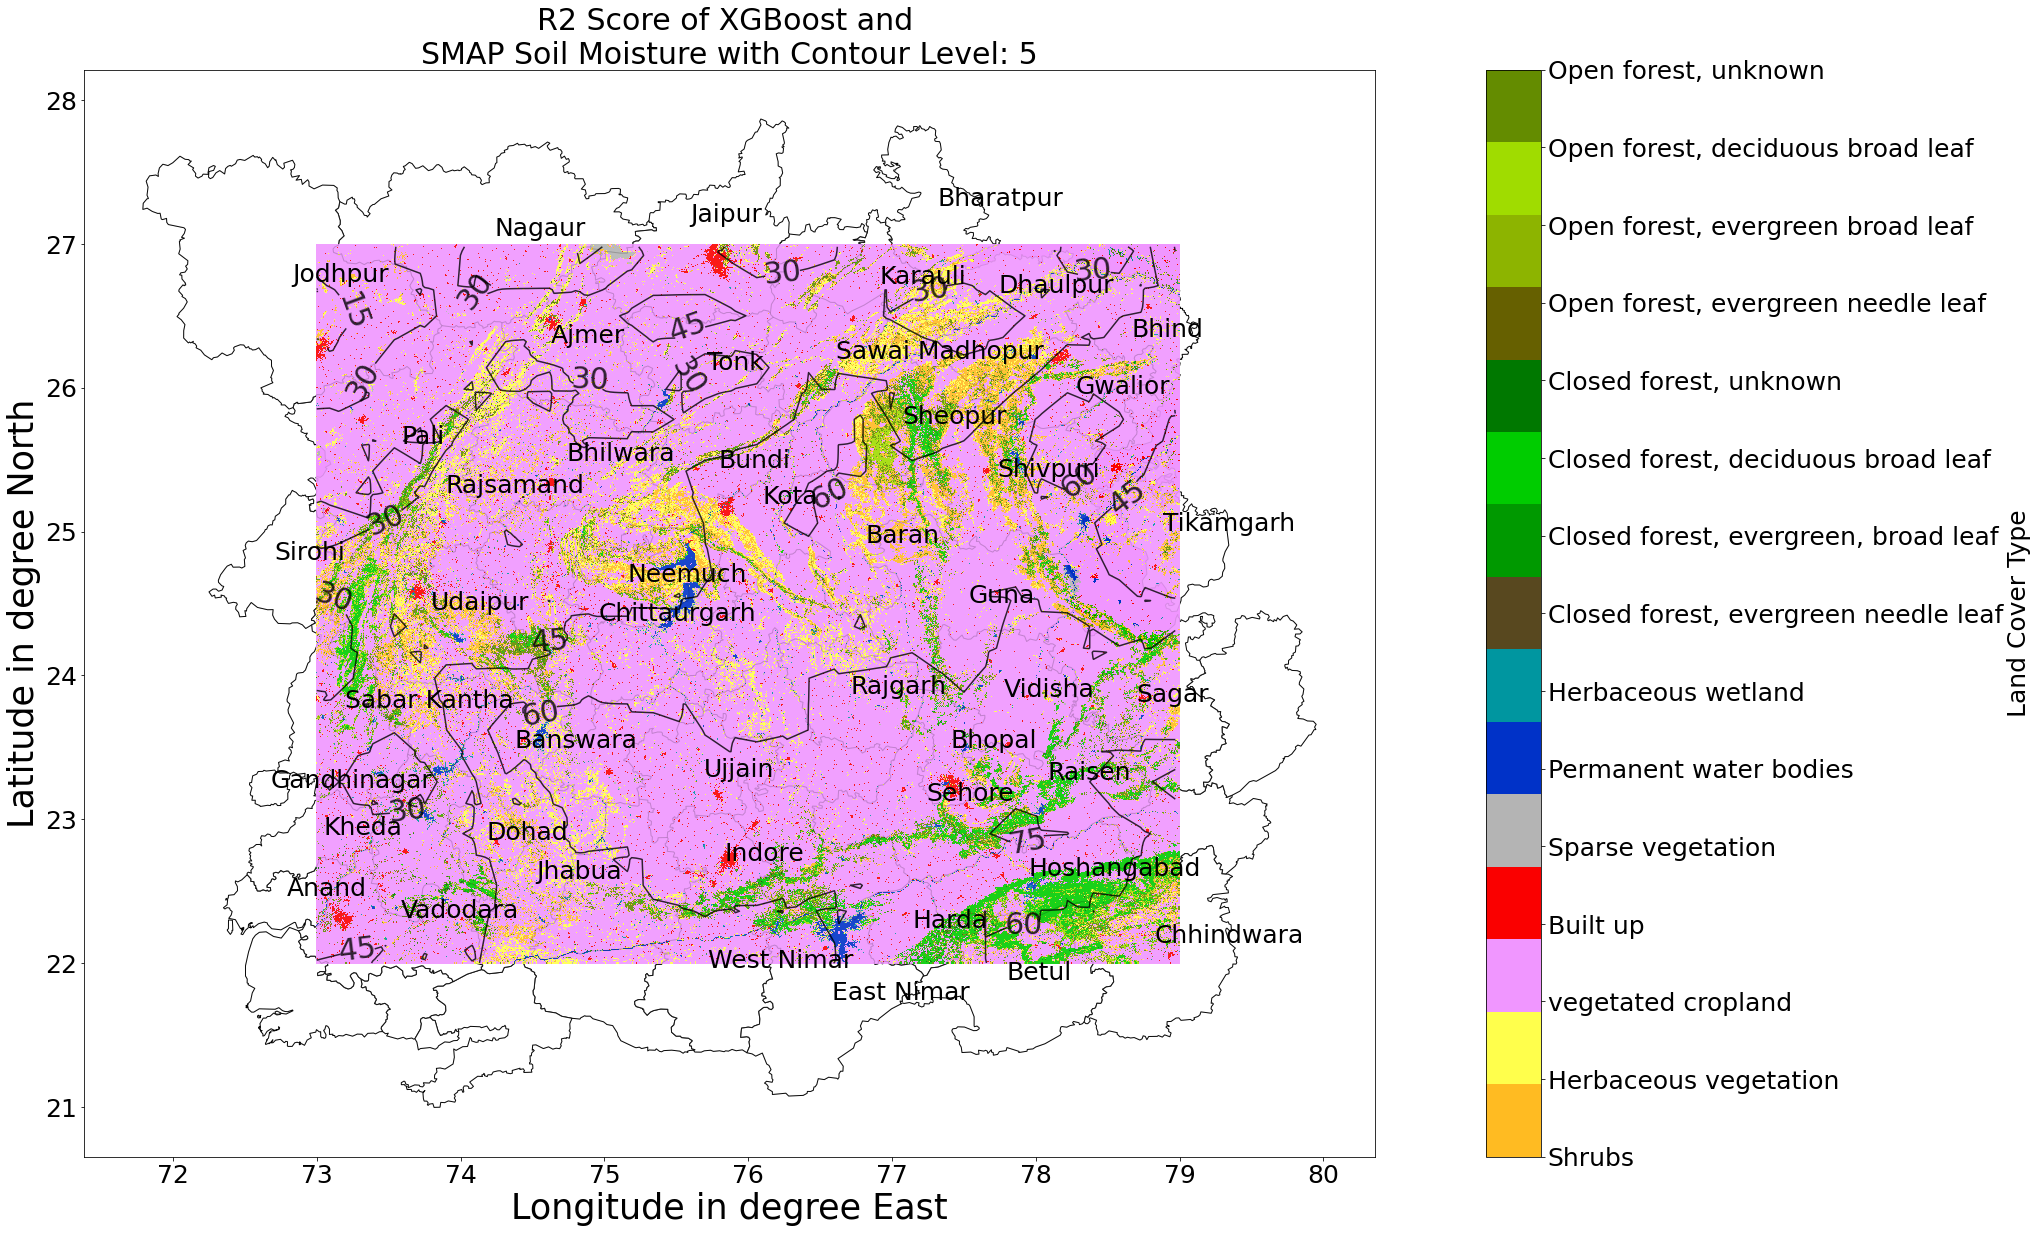

In [66]:
%%time
for i in range(len(keys1)):
  K = keys1[i]
  Plotting5(K,n1)

Wall time: 19.7 s


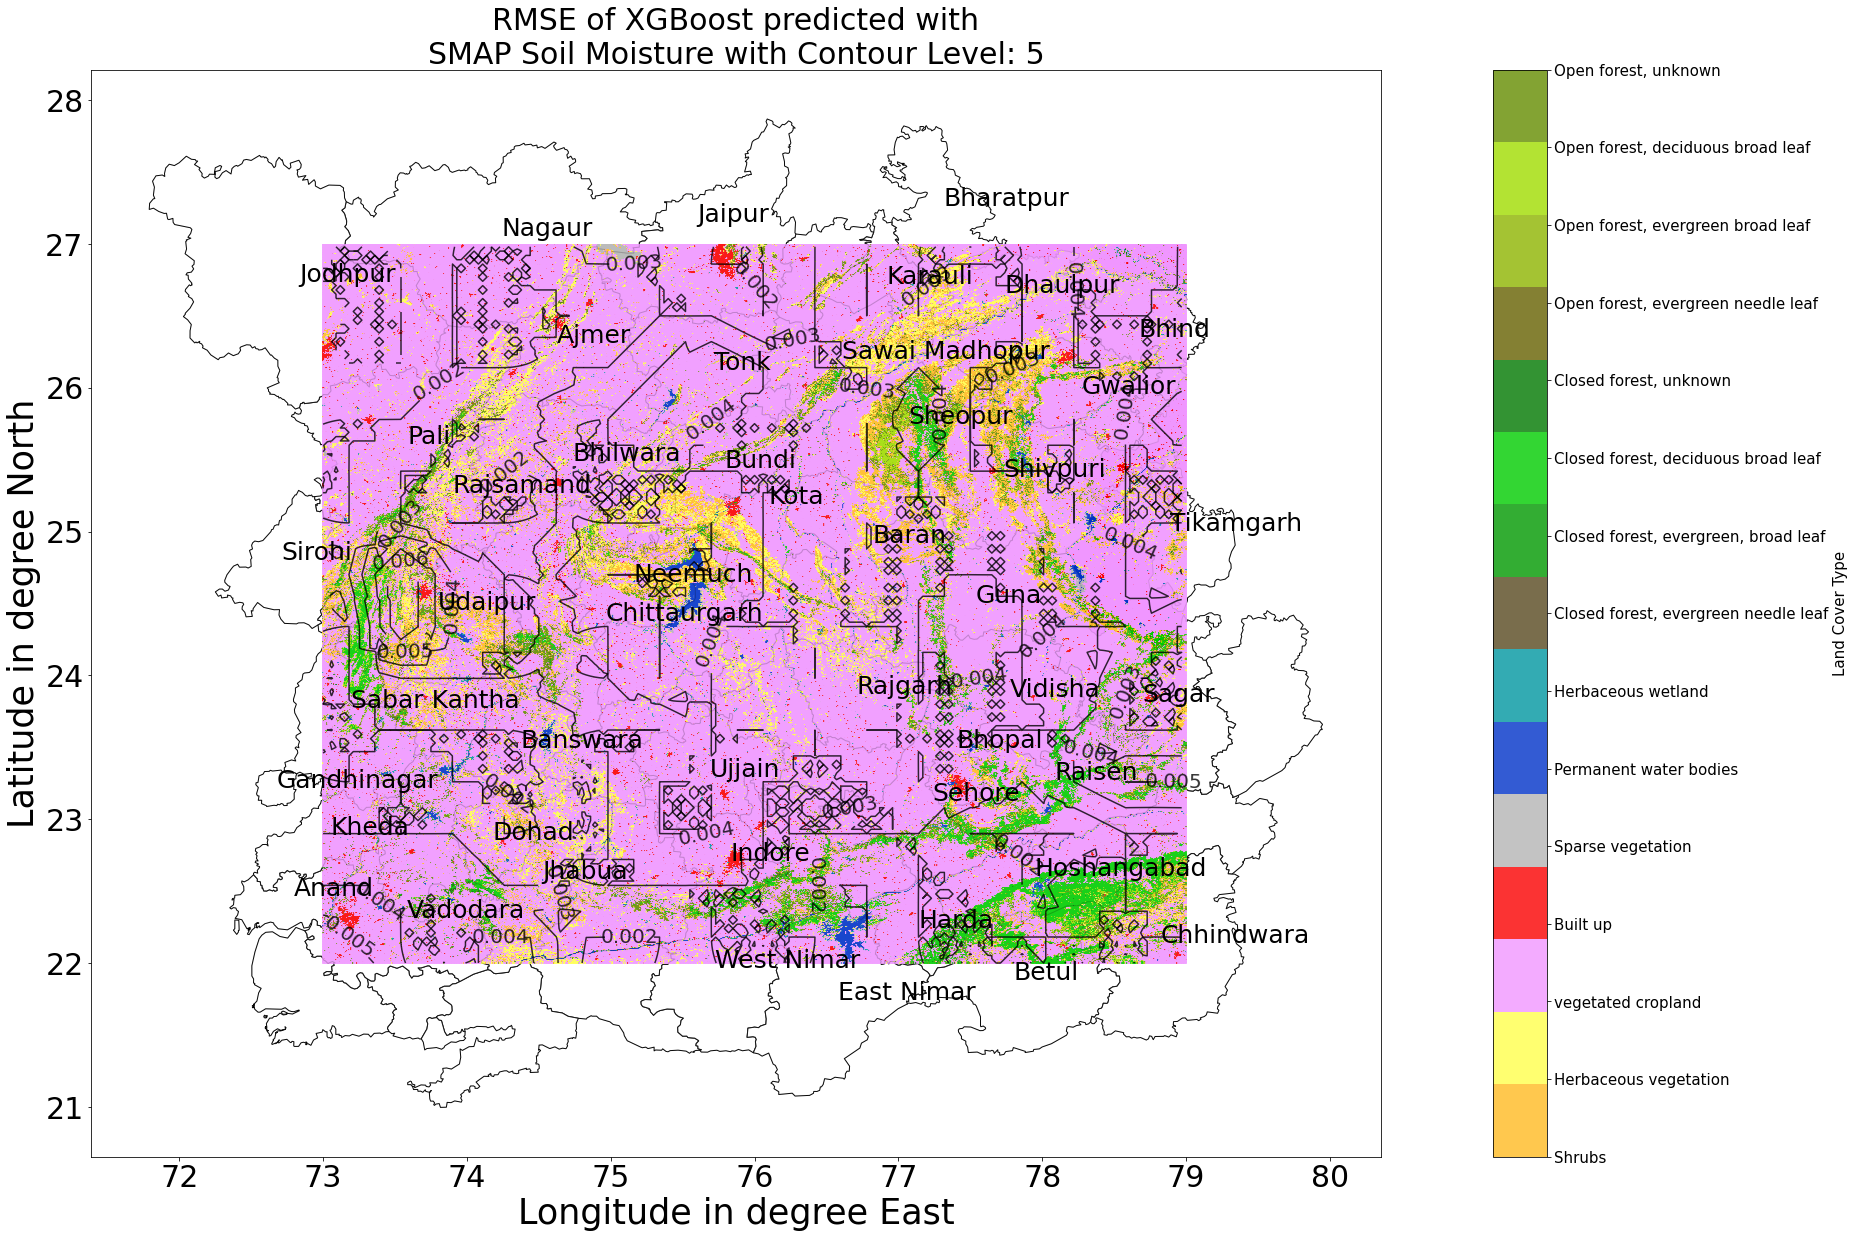

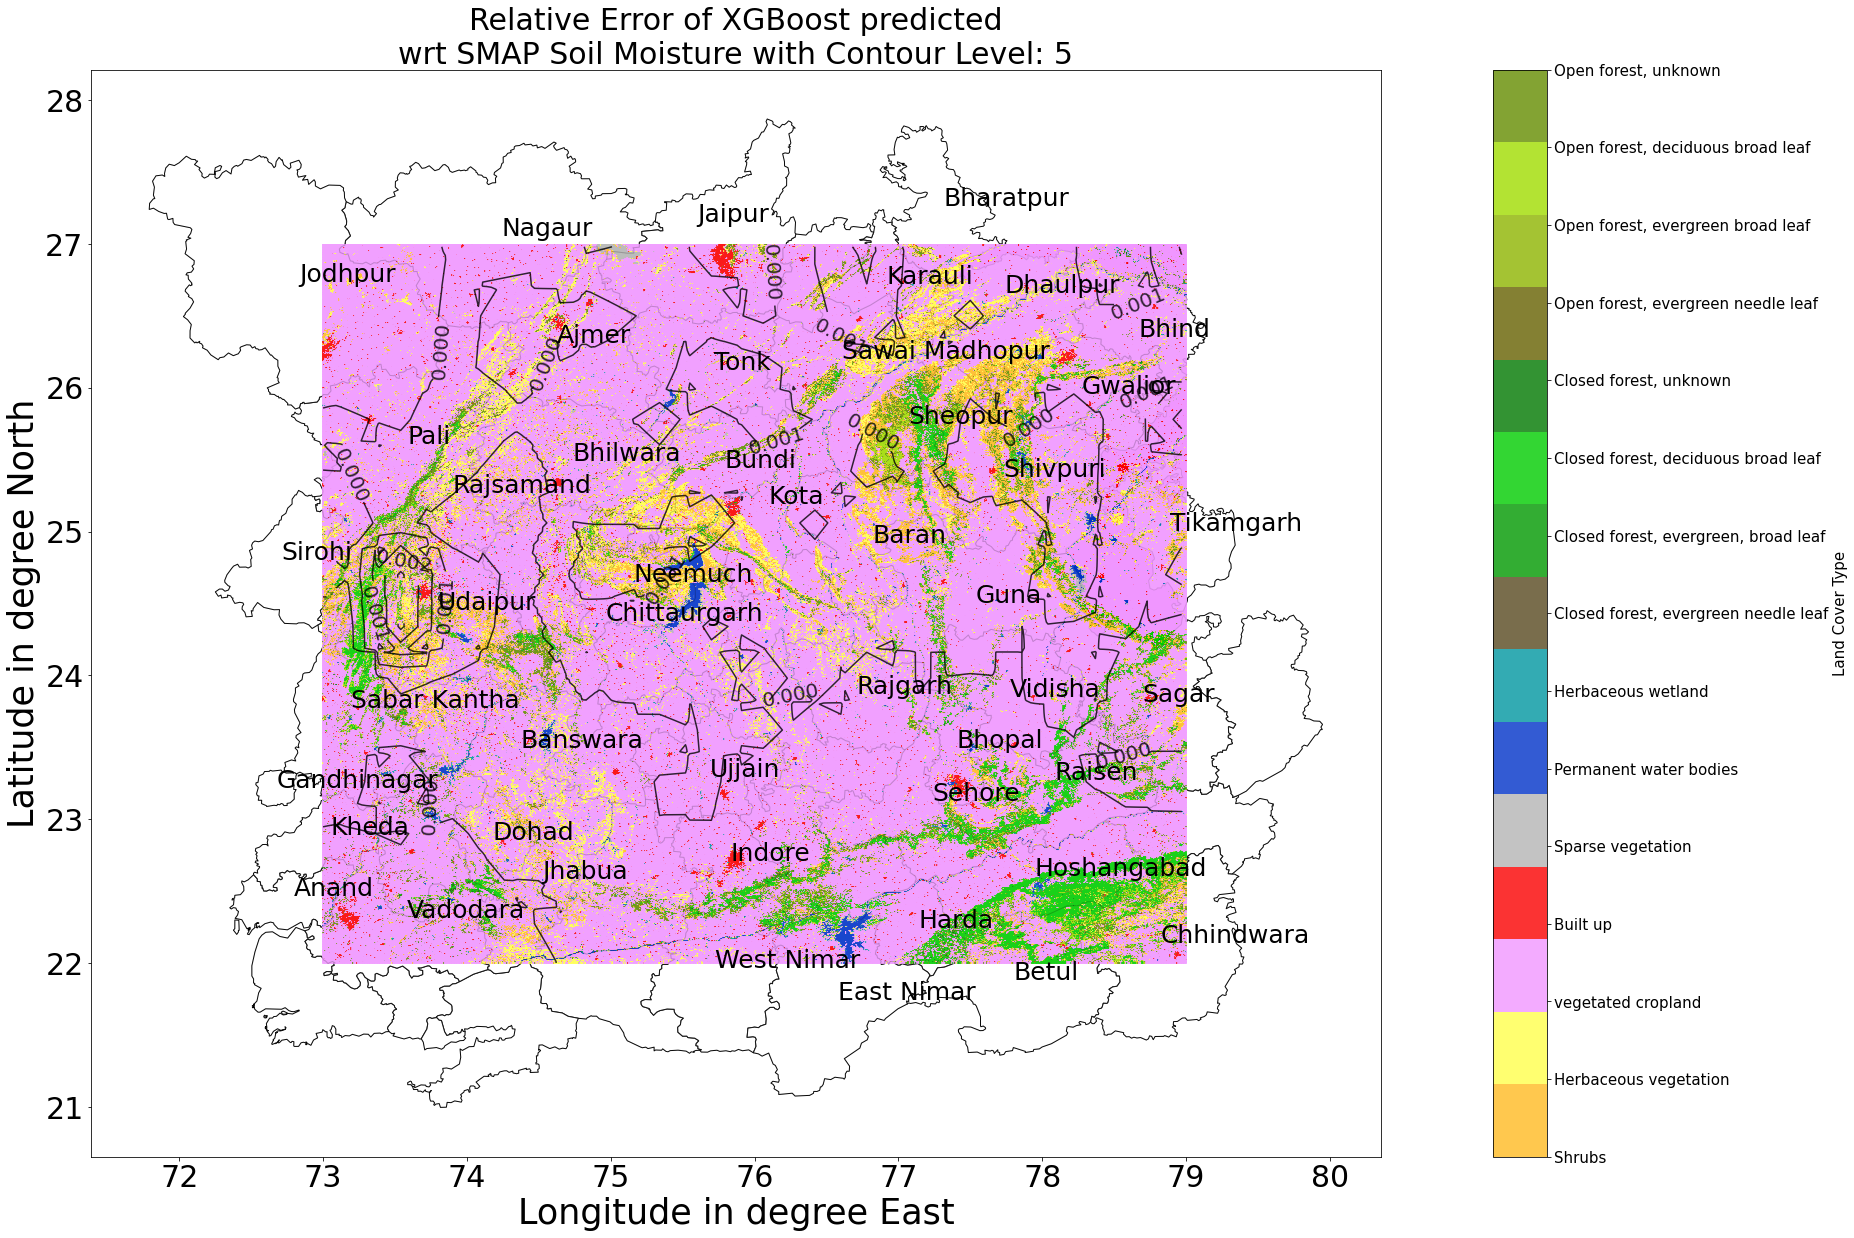

In [67]:
%%time
for i in range(len(keys2)):
  K = keys2[i]
  Plotting6(K,n1)